# Simulacao leitos - camas limitadas

In [63]:
# Import required modules

import simpy
import random
from random import expovariate, seed
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
class g:
    """g holds Global variables. No individual instance is required"""
    
    cases_arriving = 10
    inter_arrival_time = 1/cases_arriving  # Average time (days) between arrivals
    los = 13  # Average length of stay in hospital (days)
    sim_duration = 360  # Duration of simulation (days)
    audit_interval = 1  # Interval between audits (days)
    total_beds = 300
    occupation_rate = 0.5
    beds = int(total_beds * (1 - occupation_rate))  # bed capacity of hospital

In [65]:
class Hospital:
    """
    Hospital class holds:
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Admissions to data

    Methods:

    __init__: Set up hospital instance

    audit: records number of beds occupied

    build_audit_report: builds audit report at end of run (calculate 5th, 50th
    and 95th percentile bed occupancy.

    chart: plot beds occupied over time (at end of run)
    """

    def __init__(self):
        """
        Constructor method for hospital class"
        Initialise object with attributes.
        """

        self.patients = {}  # Dictionary of patients present
        self.patients_in_queue = {}
        self.patients_in_beds = {}
        self.audit_time = []  # List of audit times
        self.audit_beds = []  # List of beds occupied at each audit time
        self.audit_queue = []
        self.bed_count = 0  # Current total beds occupied
        self.queue_count = 0
        self.admissions = 0  # Admissions to data
        
        return

    def audit(self, time):
        """
        Audit method. When called appends current simulation time to audit_time
        list, and appends current bed count to audit_beds.
        """

        self.audit_time.append(time)
        self.audit_beds.append(self.bed_count)
        self.audit_queue.append(self.queue_count)
        return

    def build_audit_report(self):
        """
        This method is called at end of run. It creates a pandas DataFrame,
        transfers audit times and bed counts to the DataFrame, and 
        calculates/stores 5th, 50th and 95th percentiles.
        """
        self.audit_report = pd.DataFrame()

        self.audit_report['Time'] = self.audit_time

        self.audit_report['Occupied_beds'] = self.audit_beds

        self.audit_report['Median_beds'] = \
            self.audit_report['Occupied_beds'].quantile(0.5)

        self.audit_report['Beds_5_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.05)

        self.audit_report['Beds_95_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.95)

        self.audit_report['Queue'] = self.audit_queue

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Queue_5_percent'] = \
            self.audit_report['Queue'].quantile(0.05)

        self.audit_report['Queue_95_percent'] = \
            self.audit_report['Queue'].quantile(0.95)

        return self.audit_report

    def chart(self):
        """
        This method is called at end of run. It plots beds occupancy over the
        model run, with 5%, 50% and 95% percentiles.
        """

        # Plot occupied beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Occupied beds')
        plt.title(
            'Occupied beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()

        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for beds')
        plt.title('Queue for beds (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()

        return

In [66]:
class Model:
    """
    The main model class.

    The model class contains the model environment. The modelling environment
    is set up, and patient arrival and audit processes initiated. Patient
    arrival triggers a spell for that patient in hospital. Arrivals and audit
    continue for the duration of the model run. The audit is then 
    summarised and bed occupancy (with 5th, 50th and 95th percentiles) plotted.

    Methods are:

    __init__: Set up model instance

    audit_beds: call for bed audit at regular intervals (after initial delay 
    for model warm-up)

    new_admission: trigger new admissions to hospital at regular intervals.
    Call for patient generation with patient id and length of stay, then call
    for patient spell in hospital.

    run: Controls the main model run. Initialises model and patient arrival and
    audit processes. Instigates the run. At end of run calls for an audit
    summary and bed occupancy plot.

    spell_gen: stores patient in hospital patient list and bed queue 
    dictionaries, waits for bed resource to become available, then removes 
    patient from bed queue dictionary and adds patient to hospital bed 
    dictionary and increments beds occupied. Waits for the patient length of
    stay in the hospital and then decrements beds occupied and removes patient
    from hospital patient dictionary and beds occupied dictionary.
    """

    def __init__(self):
        """
        Constructor class for new model.
        """
        self.env = simpy.Environment()

        return

    def audit_beds(self, delay):
        """
        Bed audit process. Begins by applying delay, then calls for audit at
        intervals set in g.audit_interval

        :param delay: delay (days) at start of model run for model warm-up.
        """

        # Delay first audit
        yield self.env.timeout(delay)

        # Continually generate audit requests until end of model run
        while True:
            # Call audit (pass simulation time to hospital.audit)
            self.hospital.audit(self.env.now)
            # Delay until next call
            yield self.env.timeout(g.audit_interval)

        return

    def new_admission(self, interarrival_time, los):
        """
        New admissions to hospital.

        :param interarrival_time: average time (days) between arrivals
        :param los: average length of stay (days)
        """
        while True:
            # Increment hospital admissions count
            self.hospital.admissions += 1

            # Generate new patient object (from Patient class). Give patient id
            # and set length of stay from inverse exponential distribution).
            p = Patient(patient_id=self.hospital.admissions,
                        los=random.expovariate(1 / los))
            print('Patient %d arriving %7.2f, admissions count %d' %(p.id,self.env.now,self.hospital.admissions))

            # Add patient to hospital patient dictionary
            self.hospital.patients[p.id] = p

            # Generate a patient spell in hospital (by calling spell method).
            # This triggers a patient admission and allows the next arrival to
            # be set before the paitent spell is finished
            self.spell = self.spell_gen(p)
            self.env.process(self.spell)

            # Set and call delay before looping back to new patient admission
            next_admission = random.expovariate(1 / interarrival_time)
            #print('Next patient in %f3.2' %next_admission)
            yield self.env.timeout(next_admission)

        return

    def run(self):
        """
        Controls the main model run. Initialises model and patient arrival and
        audit processes. Instigates the run. At end of run calls for an audit
        summary and bed occupancy plot
        """

        # Set up hospital (calling Hospital class)
        self.hospital = Hospital()

        # Set up resources (beds)
        self.resources = Resources(self.env, g.beds)

        # Set up starting processes: new admissions and bed  audit (with delay)
        self.env.process(self.new_admission(g.inter_arrival_time, g.los))
        self.env.process(self.audit_beds(delay=20))

        # Start model run
        self.env.run(until=g.sim_duration)

        # At end of run call for bed audit summary and bed occupancy plot
        self.hospital.build_audit_report()
        #self.hospital.chart()

        return

    def spell_gen(self, p):
        """
        Patient hospital stay generator. Increment bed count, wait for patient
        length of stay to complete, then decrement bed count and remove patient
        from hospital patient dictionary

        :param p: patient object (contains length of stay for patient)
        """
        # The following 'with' defines the required resources and automatically
        # releases resources when no longer required

        with self.resources.beds.request() as req:
            # Increment queue count
            self.hospital.queue_count += 1
            print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

            # Add patient to dictionary of queuing patients. This is not used
            # further in this model.
            self.hospital.patients_in_queue[p.id] = p

            # Yield resource request. Sim continues after yield when resources
            # are vailable (so there is no delay if resources are immediately
            # available)
            yield req

            # Resource now available. Remove from queue count and dictionary of
            # queued objects
            self.hospital.queue_count -= 1
            del self.hospital.patients_in_queue[p.id]
            print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

            # Add to count of patients in beds and to dictionary of patients in
            # beds
            self.hospital.patients_in_beds[p.id] = p
            self.hospital.bed_count += 1
            print('Patient %d arriving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))

            # Trigger length of stay delay
            yield self.env.timeout(p.los)

            # Length of stay complete. Remove patient from counts and
            # dictionaries
            self.hospital.bed_count -= 1
            print('Patient %d leaving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
            del self.hospital.patients_in_beds[p.id]
            del self.hospital.patients[p.id]

        return

In [67]:
class Patient:
    """
    Patient class. Contains patient id and length of stay (it could contain
    other info about patient, such as priority or clinical group.

    The only method is __init__ for creating a patient (with assignment of
    patient id and length of stay).
    """

    def __init__(self, patient_id, los):
        """
        Contructor for new patient.

        :param patient_id: id of patient  (set in self.new_admission)
        :param los: length of stay (days, set in self.new_admission)
        """
        self.id = patient_id
        self.los = los

        return

In [68]:
class Resources:
    """
    Holds beds resources
    """

    def __init__(self, env, number_of_beds):
        """        Constructor method to initialise beds resource)"""
        self.beds = simpy.Resource(env, capacity=number_of_beds)

        return

In [69]:
def main():
    """
    Code entry point after: if __name__ == '__main__'
    Creates model object, and runs model
    """

    model = Model()
    model.run()

    return

In [70]:
## Code entry point. Calls main method.
#if __name__ == '__main__':
#    main()

In [71]:
model = Model()

In [72]:
%%time
seed(98989)
model.run()

Patient 1 arriving    0.00, admissions count 1
Patient 1 arriving queue    0.00, queue count 1
Patient 1 leaving queue    0.00, queue count 0
Patient 1 arriving bed    0.00, bed count 1
Patient 2 arriving    0.14, admissions count 2
Patient 2 arriving queue    0.14, queue count 1
Patient 2 leaving queue    0.14, queue count 0
Patient 2 arriving bed    0.14, bed count 2
Patient 3 arriving    0.15, admissions count 3
Patient 3 arriving queue    0.15, queue count 1
Patient 3 leaving queue    0.15, queue count 0
Patient 3 arriving bed    0.15, bed count 3
Patient 4 arriving    0.17, admissions count 4
Patient 4 arriving queue    0.17, queue count 1
Patient 4 leaving queue    0.17, queue count 0
Patient 4 arriving bed    0.17, bed count 4
Patient 5 arriving    0.27, admissions count 5
Patient 5 arriving queue    0.27, queue count 1
Patient 5 leaving queue    0.27, queue count 0
Patient 5 arriving bed    0.27, bed count 5
Patient 6 arriving    0.27, admissions count 6
Patient 6 arriving queu

Patient 58 arriving    5.81, admissions count 58
Patient 58 arriving queue    5.81, queue count 1
Patient 58 leaving queue    5.81, queue count 0
Patient 58 arriving bed    5.81, bed count 48
Patient 59 arriving    5.93, admissions count 59
Patient 59 arriving queue    5.93, queue count 1
Patient 59 leaving queue    5.93, queue count 0
Patient 59 arriving bed    5.93, bed count 49
Patient 60 arriving    6.01, admissions count 60
Patient 60 arriving queue    6.01, queue count 1
Patient 60 leaving queue    6.01, queue count 0
Patient 60 arriving bed    6.01, bed count 50
Patient 61 arriving    6.04, admissions count 61
Patient 61 arriving queue    6.04, queue count 1
Patient 61 leaving queue    6.04, queue count 0
Patient 61 arriving bed    6.04, bed count 51
Patient 62 arriving    6.08, admissions count 62
Patient 62 arriving queue    6.08, queue count 1
Patient 62 leaving queue    6.08, queue count 0
Patient 62 arriving bed    6.08, bed count 52
Patient 63 arriving    6.18, admissions 

Patient 149 arriving   14.18, admissions count 149
Patient 149 arriving queue   14.18, queue count 1
Patient 149 leaving queue   14.18, queue count 0
Patient 149 arriving bed   14.18, bed count 87
Patient 124 leaving bed   14.32, bed count 86
Patient 150 arriving   14.35, admissions count 150
Patient 150 arriving queue   14.35, queue count 1
Patient 150 leaving queue   14.35, queue count 0
Patient 150 arriving bed   14.35, bed count 87
Patient 151 arriving   14.39, admissions count 151
Patient 151 arriving queue   14.39, queue count 1
Patient 151 leaving queue   14.39, queue count 0
Patient 151 arriving bed   14.39, bed count 88
Patient 152 arriving   14.63, admissions count 152
Patient 152 arriving queue   14.63, queue count 1
Patient 152 leaving queue   14.63, queue count 0
Patient 152 arriving bed   14.63, bed count 89
Patient 152 leaving bed   14.65, bed count 88
Patient 153 arriving   14.69, admissions count 153
Patient 153 arriving queue   14.69, queue count 1
Patient 153 leaving

Patient 295 arriving bed   28.59, bed count 105
Patient 190 leaving bed   28.60, bed count 104
Patient 296 arriving   28.64, admissions count 296
Patient 296 arriving queue   28.64, queue count 1
Patient 296 leaving queue   28.64, queue count 0
Patient 296 arriving bed   28.64, bed count 105
Patient 297 arriving   28.68, admissions count 297
Patient 297 arriving queue   28.68, queue count 1
Patient 297 leaving queue   28.68, queue count 0
Patient 297 arriving bed   28.68, bed count 106
Patient 298 arriving   28.69, admissions count 298
Patient 298 arriving queue   28.69, queue count 1
Patient 298 leaving queue   28.69, queue count 0
Patient 298 arriving bed   28.69, bed count 107
Patient 299 arriving   28.74, admissions count 299
Patient 299 arriving queue   28.74, queue count 1
Patient 299 leaving queue   28.74, queue count 0
Patient 299 arriving bed   28.74, bed count 108
Patient 300 arriving   28.77, admissions count 300
Patient 300 arriving queue   28.77, queue count 1
Patient 300 

Patient 445 arriving   42.79, admissions count 445
Patient 445 arriving queue   42.79, queue count 1
Patient 445 leaving queue   42.79, queue count 0
Patient 445 arriving bed   42.79, bed count 124
Patient 446 arriving   42.86, admissions count 446
Patient 446 arriving queue   42.86, queue count 1
Patient 446 leaving queue   42.86, queue count 0
Patient 446 arriving bed   42.86, bed count 125
Patient 447 arriving   42.90, admissions count 447
Patient 447 arriving queue   42.90, queue count 1
Patient 447 leaving queue   42.90, queue count 0
Patient 447 arriving bed   42.90, bed count 126
Patient 421 leaving bed   42.91, bed count 125
Patient 448 arriving   42.92, admissions count 448
Patient 448 arriving queue   42.92, queue count 1
Patient 448 leaving queue   42.92, queue count 0
Patient 448 arriving bed   42.92, bed count 126
Patient 449 arriving   43.04, admissions count 449
Patient 449 arriving queue   43.04, queue count 1
Patient 449 leaving queue   43.04, queue count 0
Patient 449

Patient 585 leaving queue   54.86, queue count 2
Patient 585 arriving bed   54.86, bed count 150
Patient 588 arriving   54.89, admissions count 588
Patient 588 arriving queue   54.89, queue count 3
Patient 442 leaving bed   55.13, bed count 149
Patient 586 leaving queue   55.13, queue count 2
Patient 586 arriving bed   55.13, bed count 150
Patient 498 leaving bed   55.20, bed count 149
Patient 587 leaving queue   55.20, queue count 1
Patient 587 arriving bed   55.20, bed count 150
Patient 589 arriving   55.22, admissions count 589
Patient 589 arriving queue   55.22, queue count 2
Patient 181 leaving bed   55.28, bed count 149
Patient 588 leaving queue   55.28, queue count 1
Patient 588 arriving bed   55.28, bed count 150
Patient 410 leaving bed   55.35, bed count 149
Patient 589 leaving queue   55.35, queue count 0
Patient 589 arriving bed   55.35, bed count 150
Patient 590 arriving   55.37, admissions count 590
Patient 590 arriving queue   55.37, queue count 1
Patient 550 leaving bed 

Patient 639 leaving bed   75.83, bed count 132
Patient 781 arriving   75.86, admissions count 781
Patient 781 arriving queue   75.86, queue count 1
Patient 781 leaving queue   75.86, queue count 0
Patient 781 arriving bed   75.86, bed count 133
Patient 782 arriving   75.89, admissions count 782
Patient 782 arriving queue   75.89, queue count 1
Patient 782 leaving queue   75.89, queue count 0
Patient 782 arriving bed   75.89, bed count 134
Patient 727 leaving bed   75.96, bed count 133
Patient 783 arriving   76.01, admissions count 783
Patient 783 arriving queue   76.01, queue count 1
Patient 783 leaving queue   76.01, queue count 0
Patient 783 arriving bed   76.01, bed count 134
Patient 644 leaving bed   76.01, bed count 133
Patient 728 leaving bed   76.09, bed count 132
Patient 784 arriving   76.17, admissions count 784
Patient 784 arriving queue   76.17, queue count 1
Patient 784 leaving queue   76.17, queue count 0
Patient 784 arriving bed   76.17, bed count 133
Patient 759 leaving 

Patient 857 leaving queue   84.23, queue count 0
Patient 857 arriving bed   84.23, bed count 128
Patient 853 leaving bed   84.31, bed count 127
Patient 611 leaving bed   84.34, bed count 126
Patient 858 arriving   84.36, admissions count 858
Patient 858 arriving queue   84.36, queue count 1
Patient 858 leaving queue   84.36, queue count 0
Patient 858 arriving bed   84.36, bed count 127
Patient 850 leaving bed   84.37, bed count 126
Patient 839 leaving bed   84.45, bed count 125
Patient 705 leaving bed   84.47, bed count 124
Patient 715 leaving bed   84.49, bed count 123
Patient 840 leaving bed   84.55, bed count 122
Patient 702 leaving bed   84.60, bed count 121
Patient 845 leaving bed   84.61, bed count 120
Patient 859 arriving   84.75, admissions count 859
Patient 859 arriving queue   84.75, queue count 1
Patient 859 leaving queue   84.75, queue count 0
Patient 859 arriving bed   84.75, bed count 121
Patient 786 leaving bed   84.87, bed count 120
Patient 860 arriving   84.90, admissi

Patient 1092 arriving queue  107.59, queue count 1
Patient 1092 leaving queue  107.59, queue count 0
Patient 1092 arriving bed  107.59, bed count 124
Patient 1093 arriving  107.61, admissions count 1093
Patient 1093 arriving queue  107.61, queue count 1
Patient 1093 leaving queue  107.61, queue count 0
Patient 1093 arriving bed  107.61, bed count 125
Patient 1094 arriving  107.61, admissions count 1094
Patient 1094 arriving queue  107.61, queue count 1
Patient 1094 leaving queue  107.61, queue count 0
Patient 1094 arriving bed  107.61, bed count 126
Patient 1066 leaving bed  107.66, bed count 125
Patient 1095 arriving  107.67, admissions count 1095
Patient 1095 arriving queue  107.67, queue count 1
Patient 1095 leaving queue  107.67, queue count 0
Patient 1095 arriving bed  107.67, bed count 126
Patient 814 leaving bed  107.77, bed count 125
Patient 1096 arriving  107.79, admissions count 1096
Patient 1096 arriving queue  107.79, queue count 1
Patient 1096 leaving queue  107.79, queue 

Patient 1256 arriving bed  124.91, bed count 113
Patient 1257 arriving  124.94, admissions count 1257
Patient 1257 arriving queue  124.94, queue count 1
Patient 1257 leaving queue  124.94, queue count 0
Patient 1257 arriving bed  124.94, bed count 114
Patient 1251 leaving bed  124.96, bed count 113
Patient 1158 leaving bed  125.04, bed count 112
Patient 1258 arriving  125.05, admissions count 1258
Patient 1258 arriving queue  125.05, queue count 1
Patient 1258 leaving queue  125.05, queue count 0
Patient 1258 arriving bed  125.05, bed count 113
Patient 1253 leaving bed  125.25, bed count 112
Patient 1205 leaving bed  125.50, bed count 111
Patient 1154 leaving bed  125.77, bed count 110
Patient 1234 leaving bed  125.77, bed count 109
Patient 1259 arriving  125.89, admissions count 1259
Patient 1259 arriving queue  125.89, queue count 1
Patient 1259 leaving queue  125.89, queue count 0
Patient 1259 arriving bed  125.89, bed count 110
Patient 1260 arriving  125.94, admissions count 1260
P

Patient 1390 arriving bed  138.62, bed count 117
Patient 1391 arriving  138.63, admissions count 1391
Patient 1391 arriving queue  138.63, queue count 1
Patient 1391 leaving queue  138.63, queue count 0
Patient 1391 arriving bed  138.63, bed count 118
Patient 1392 arriving  138.84, admissions count 1392
Patient 1392 arriving queue  138.84, queue count 1
Patient 1392 leaving queue  138.84, queue count 0
Patient 1392 arriving bed  138.84, bed count 119
Patient 1393 arriving  138.88, admissions count 1393
Patient 1393 arriving queue  138.88, queue count 1
Patient 1393 leaving queue  138.88, queue count 0
Patient 1393 arriving bed  138.88, bed count 120
Patient 1394 arriving  138.95, admissions count 1394
Patient 1394 arriving queue  138.95, queue count 1
Patient 1394 leaving queue  138.95, queue count 0
Patient 1394 arriving bed  138.95, bed count 121
Patient 1395 arriving  138.97, admissions count 1395
Patient 1395 arriving queue  138.97, queue count 1
Patient 1395 leaving queue  138.97,

Patient 1592 leaving queue  157.05, queue count 0
Patient 1592 arriving bed  157.05, bed count 139
Patient 1593 arriving  157.05, admissions count 1593
Patient 1593 arriving queue  157.05, queue count 1
Patient 1593 leaving queue  157.05, queue count 0
Patient 1593 arriving bed  157.05, bed count 140
Patient 1409 leaving bed  157.11, bed count 139
Patient 1566 leaving bed  157.20, bed count 138
Patient 1568 leaving bed  157.25, bed count 137
Patient 1425 leaving bed  157.29, bed count 136
Patient 1513 leaving bed  157.29, bed count 135
Patient 1505 leaving bed  157.31, bed count 134
Patient 1583 leaving bed  157.34, bed count 133
Patient 1594 arriving  157.41, admissions count 1594
Patient 1594 arriving queue  157.41, queue count 1
Patient 1594 leaving queue  157.41, queue count 0
Patient 1594 arriving bed  157.41, bed count 134
Patient 1595 arriving  157.45, admissions count 1595
Patient 1595 arriving queue  157.45, queue count 1
Patient 1595 leaving queue  157.45, queue count 0
Patie

Patient 1688 leaving queue  168.21, queue count 0
Patient 1688 arriving bed  168.21, bed count 107
Patient 1689 arriving  168.34, admissions count 1689
Patient 1689 arriving queue  168.34, queue count 1
Patient 1689 leaving queue  168.34, queue count 0
Patient 1689 arriving bed  168.34, bed count 108
Patient 1690 arriving  168.42, admissions count 1690
Patient 1690 arriving queue  168.42, queue count 1
Patient 1690 leaving queue  168.42, queue count 0
Patient 1690 arriving bed  168.42, bed count 109
Patient 1506 leaving bed  168.49, bed count 108
Patient 1691 arriving  168.59, admissions count 1691
Patient 1691 arriving queue  168.59, queue count 1
Patient 1691 leaving queue  168.59, queue count 0
Patient 1691 arriving bed  168.59, bed count 109
Patient 1692 arriving  168.63, admissions count 1692
Patient 1692 arriving queue  168.63, queue count 1
Patient 1692 leaving queue  168.63, queue count 0
Patient 1692 arriving bed  168.63, bed count 110
Patient 1693 arriving  168.63, admissions

Patient 1843 arriving  186.96, admissions count 1843
Patient 1843 arriving queue  186.96, queue count 1
Patient 1843 leaving queue  186.96, queue count 0
Patient 1843 arriving bed  186.96, bed count 100
Patient 1590 leaving bed  187.02, bed count 99
Patient 1844 arriving  187.18, admissions count 1844
Patient 1844 arriving queue  187.18, queue count 1
Patient 1844 leaving queue  187.18, queue count 0
Patient 1844 arriving bed  187.18, bed count 100
Patient 1684 leaving bed  187.19, bed count 99
Patient 1798 leaving bed  187.25, bed count 98
Patient 1845 arriving  187.25, admissions count 1845
Patient 1845 arriving queue  187.25, queue count 1
Patient 1845 leaving queue  187.25, queue count 0
Patient 1845 arriving bed  187.25, bed count 99
Patient 1846 arriving  187.42, admissions count 1846
Patient 1846 arriving queue  187.42, queue count 1
Patient 1846 leaving queue  187.42, queue count 0
Patient 1846 arriving bed  187.42, bed count 100
Patient 1847 arriving  187.49, admissions count 

Patient 1990 arriving bed  203.44, bed count 119
Patient 1991 arriving  203.47, admissions count 1991
Patient 1991 arriving queue  203.47, queue count 1
Patient 1991 leaving queue  203.47, queue count 0
Patient 1991 arriving bed  203.47, bed count 120
Patient 1871 leaving bed  203.48, bed count 119
Patient 1968 leaving bed  203.51, bed count 118
Patient 1290 leaving bed  203.51, bed count 117
Patient 1992 arriving  203.68, admissions count 1992
Patient 1992 arriving queue  203.68, queue count 1
Patient 1992 leaving queue  203.68, queue count 0
Patient 1992 arriving bed  203.68, bed count 118
Patient 1993 arriving  203.71, admissions count 1993
Patient 1993 arriving queue  203.71, queue count 1
Patient 1993 leaving queue  203.71, queue count 0
Patient 1993 arriving bed  203.71, bed count 119
Patient 1856 leaving bed  203.71, bed count 118
Patient 1891 leaving bed  203.80, bed count 117
Patient 1776 leaving bed  203.83, bed count 116
Patient 1994 arriving  203.84, admissions count 1994
P

Patient 2196 leaving queue  222.01, queue count 0
Patient 2196 arriving bed  222.01, bed count 148
Patient 2197 arriving  222.10, admissions count 2197
Patient 2197 arriving queue  222.10, queue count 1
Patient 2197 leaving queue  222.10, queue count 0
Patient 2197 arriving bed  222.10, bed count 149
Patient 2198 arriving  222.12, admissions count 2198
Patient 2198 arriving queue  222.12, queue count 1
Patient 2198 leaving queue  222.12, queue count 0
Patient 2198 arriving bed  222.12, bed count 150
Patient 2199 arriving  222.28, admissions count 2199
Patient 2199 arriving queue  222.28, queue count 1
Patient 1971 leaving bed  222.33, bed count 149
Patient 2199 leaving queue  222.33, queue count 0
Patient 2199 arriving bed  222.33, bed count 150
Patient 2165 leaving bed  222.36, bed count 149
Patient 2134 leaving bed  222.36, bed count 148
Patient 2200 arriving  222.39, admissions count 2200
Patient 2200 arriving queue  222.39, queue count 1
Patient 2200 leaving queue  222.39, queue co

Patient 2147 leaving bed  240.91, bed count 140
Patient 2395 arriving  240.91, admissions count 2395
Patient 2395 arriving queue  240.91, queue count 1
Patient 2395 leaving queue  240.91, queue count 0
Patient 2395 arriving bed  240.91, bed count 141
Patient 2396 arriving  240.96, admissions count 2396
Patient 2396 arriving queue  240.96, queue count 1
Patient 2396 leaving queue  240.96, queue count 0
Patient 2396 arriving bed  240.96, bed count 142
Patient 2093 leaving bed  240.97, bed count 141
Patient 1958 leaving bed  241.00, bed count 140
Patient 2397 arriving  241.17, admissions count 2397
Patient 2397 arriving queue  241.17, queue count 1
Patient 2397 leaving queue  241.17, queue count 0
Patient 2397 arriving bed  241.17, bed count 141
Patient 2341 leaving bed  241.19, bed count 140
Patient 2328 leaving bed  241.28, bed count 139
Patient 2366 leaving bed  241.29, bed count 138
Patient 2398 arriving  241.30, admissions count 2398
Patient 2398 arriving queue  241.30, queue count 1

Patient 2590 arriving bed  260.65, bed count 120
Patient 2464 leaving bed  260.75, bed count 119
Patient 2591 arriving  260.76, admissions count 2591
Patient 2591 arriving queue  260.76, queue count 1
Patient 2591 leaving queue  260.76, queue count 0
Patient 2591 arriving bed  260.76, bed count 120
Patient 2452 leaving bed  260.77, bed count 119
Patient 2592 arriving  260.80, admissions count 2592
Patient 2592 arriving queue  260.80, queue count 1
Patient 2592 leaving queue  260.80, queue count 0
Patient 2592 arriving bed  260.80, bed count 120
Patient 2593 arriving  260.81, admissions count 2593
Patient 2593 arriving queue  260.81, queue count 1
Patient 2593 leaving queue  260.81, queue count 0
Patient 2593 arriving bed  260.81, bed count 121
Patient 2594 arriving  260.85, admissions count 2594
Patient 2594 arriving queue  260.85, queue count 1
Patient 2594 leaving queue  260.85, queue count 0
Patient 2594 arriving bed  260.85, bed count 122
Patient 2421 leaving bed  260.89, bed count

Patient 2791 leaving queue  279.82, queue count 0
Patient 2791 arriving bed  279.82, bed count 125
Patient 2789 leaving bed  279.88, bed count 124
Patient 2792 arriving  279.97, admissions count 2792
Patient 2792 arriving queue  279.97, queue count 1
Patient 2792 leaving queue  279.97, queue count 0
Patient 2792 arriving bed  279.97, bed count 125
Patient 2793 arriving  280.00, admissions count 2793
Patient 2793 arriving queue  280.00, queue count 1
Patient 2793 leaving queue  280.00, queue count 0
Patient 2793 arriving bed  280.00, bed count 126
Patient 2676 leaving bed  280.03, bed count 125
Patient 2794 arriving  280.08, admissions count 2794
Patient 2794 arriving queue  280.08, queue count 1
Patient 2794 leaving queue  280.08, queue count 0
Patient 2794 arriving bed  280.08, bed count 126
Patient 2795 arriving  280.20, admissions count 2795
Patient 2795 arriving queue  280.20, queue count 1
Patient 2795 leaving queue  280.20, queue count 0
Patient 2795 arriving bed  280.20, bed cou

Patient 2991 arriving  300.55, admissions count 2991
Patient 2991 arriving queue  300.55, queue count 1
Patient 2991 leaving queue  300.55, queue count 0
Patient 2991 arriving bed  300.55, bed count 123
Patient 2992 arriving  300.57, admissions count 2992
Patient 2992 arriving queue  300.57, queue count 1
Patient 2992 leaving queue  300.57, queue count 0
Patient 2992 arriving bed  300.57, bed count 124
Patient 2993 arriving  300.58, admissions count 2993
Patient 2993 arriving queue  300.58, queue count 1
Patient 2993 leaving queue  300.58, queue count 0
Patient 2993 arriving bed  300.58, bed count 125
Patient 2994 arriving  300.73, admissions count 2994
Patient 2994 arriving queue  300.73, queue count 1
Patient 2994 leaving queue  300.73, queue count 0
Patient 2994 arriving bed  300.73, bed count 126
Patient 2995 arriving  300.89, admissions count 2995
Patient 2995 arriving queue  300.89, queue count 1
Patient 2995 leaving queue  300.89, queue count 0
Patient 2995 arriving bed  300.89,

Patient 3192 arriving bed  319.53, bed count 132
Patient 3193 arriving  319.56, admissions count 3193
Patient 3193 arriving queue  319.56, queue count 1
Patient 3193 leaving queue  319.56, queue count 0
Patient 3193 arriving bed  319.56, bed count 133
Patient 3189 leaving bed  319.60, bed count 132
Patient 3167 leaving bed  319.61, bed count 131
Patient 2939 leaving bed  319.76, bed count 130
Patient 3194 arriving  319.85, admissions count 3194
Patient 3194 arriving queue  319.85, queue count 1
Patient 3194 leaving queue  319.85, queue count 0
Patient 3194 arriving bed  319.85, bed count 131
Patient 3013 leaving bed  319.88, bed count 130
Patient 3124 leaving bed  319.98, bed count 129
Patient 3193 leaving bed  320.00, bed count 128
Patient 3195 arriving  320.03, admissions count 3195
Patient 3195 arriving queue  320.03, queue count 1
Patient 3195 leaving queue  320.03, queue count 0
Patient 3195 arriving bed  320.03, bed count 129
Patient 3021 leaving bed  320.04, bed count 128
Patien

Patient 3391 arriving bed  339.67, bed count 127
Patient 3392 arriving  339.76, admissions count 3392
Patient 3392 arriving queue  339.76, queue count 1
Patient 3392 leaving queue  339.76, queue count 0
Patient 3392 arriving bed  339.76, bed count 128
Patient 3393 arriving  339.76, admissions count 3393
Patient 3393 arriving queue  339.76, queue count 1
Patient 3393 leaving queue  339.76, queue count 0
Patient 3393 arriving bed  339.76, bed count 129
Patient 3373 leaving bed  339.84, bed count 128
Patient 3366 leaving bed  339.89, bed count 127
Patient 3155 leaving bed  339.90, bed count 126
Patient 3194 leaving bed  339.93, bed count 125
Patient 3394 arriving  340.09, admissions count 3394
Patient 3394 arriving queue  340.09, queue count 1
Patient 3394 leaving queue  340.09, queue count 0
Patient 3394 arriving bed  340.09, bed count 126
Patient 3395 arriving  340.11, admissions count 3395
Patient 3395 arriving queue  340.11, queue count 1
Patient 3395 leaving queue  340.11, queue coun

In [73]:
model.hospital.build_audit_report().head()

,Time,Occupied_beds,Median_beds,Beds_5_percent,Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent
0,20,102,127.0,102.0,148.0,0,0.0,0.0,0.0
1,21,104,127.0,102.0,148.0,0,0.0,0.0,0.0
2,22,110,127.0,102.0,148.0,0,0.0,0.0,0.0
3,23,104,127.0,102.0,148.0,0,0.0,0.0,0.0
4,24,111,127.0,102.0,148.0,0,0.0,0.0,0.0


In [74]:
model.hospital.build_audit_report().tail()

,Time,Occupied_beds,Median_beds,Beds_5_percent,Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent
335,355,115,127.0,102.0,148.0,0,0.0,0.0,0.0
336,356,113,127.0,102.0,148.0,0,0.0,0.0,0.0
337,357,118,127.0,102.0,148.0,0,0.0,0.0,0.0
338,358,115,127.0,102.0,148.0,0,0.0,0.0,0.0
339,359,116,127.0,102.0,148.0,0,0.0,0.0,0.0


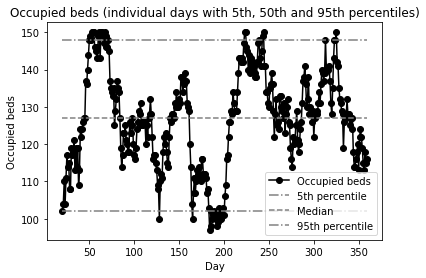

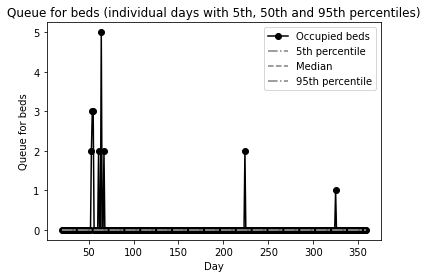

In [75]:
model.hospital.chart()